## TPE Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH_TWO_P")
dataset = pd.read_csv(dataset_path)
dataset.head()

,Gender,Age,DIAGNOSIS,MMSE,Hip ASM,Hip Contrast,Hip Correlation,Hip Variance,Hip Sum Average,Hip Sum Variance,...,ERC CONTRAST,ERC CORRELATION,ERC VARIANCE,ERC SUM AVERAGE,ERC SUM VARIANCE,ERC ENTROPY,ERC CLUSTER SHADE,ERCs_thicknessbaseline,ERCsVolumebaseline,TOTAL_HIPPOCAMPUS_VOLUME
0,0,65.149895,0,30.0,0.460200,83.371297,0.508610,89.066304,10.318461,272.893918,...,245.139997,0.385395,209.332939,41.129640,592.191757,3.234648,18110.527190,6.948,2826,6861.9
1,1,67.206024,0,30.0,0.329647,149.712265,0.328176,109.824210,13.761403,289.584573,...,221.932844,0.406722,197.689209,42.149774,568.823992,3.240436,23801.869010,7.090,3792,7378.1
2,0,58.773440,0,30.0,0.385797,104.769354,0.545986,125.678783,15.521177,397.945779,...,283.711655,0.336695,217.002950,41.289080,584.300146,3.069283,17579.374770,6.832,2964,7983.5
3,0,55.096508,0,30.0,0.229011,166.953431,0.275601,112.186834,18.126786,281.793906,...,231.188679,0.498026,232.827358,33.062621,700.120751,3.093719,4888.606116,6.523,3184,8525.1
4,0,48.030117,0,29.0,0.242913,86.816221,0.377439,73.484651,13.463920,207.122381,...,245.120671,0.458936,233.016858,44.574015,686.946759,3.149858,22134.931110,8.253,3419,9320.5


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("DIAGNOSIS", axis=1),  
    dataset["DIAGNOSIS"],  
    test_size=0.3,  
    random_state=42,  
)

X_train.shape, X_test.shape

((522, 22), (224, 22))

In [4]:
imputer_knn = IterativeImputer(
    estimator=KNeighborsRegressor(),
    random_state=42,
)

imputer_knn.fit(X_train)
X_train_knn = imputer_knn.transform(X_train)
X_test_knn = imputer_knn.transform(X_test)

In [5]:
X_train_knn_t = pd.DataFrame(
    X_train_knn, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_knn_t = pd.DataFrame(
    X_test_knn, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [6]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_knn_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [7]:
X_train_t = pipe.transform(X_train_knn_t)
X_test_t = pipe.transform(X_test_knn_t)

X_train_t.shape, X_test_t.shape

((522, 22), (224, 22))

In [8]:
sel = ['Age', 'MMSE', 'Hip Entropy', 'ERC ENTROPY', 'ERCs_thicknessbaseline',
       'ERCsVolumebaseline', 'TOTAL_HIPPOCAMPUS_VOLUME']

In [9]:
selected_features = [col for col in sel if col in X_train_t.columns]
selected_features

['Age',
 'MMSE',
 'Hip Entropy',
 'ERC ENTROPY',
 'ERCs_thicknessbaseline',
 'ERCsVolumebaseline',
 'TOTAL_HIPPOCAMPUS_VOLUME']

In [10]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((522, 7), (224, 7))

## TPE

In [11]:
scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train_t)
X_test_t = scaler.transform(X_test_t)

In [12]:
def objective(trial):
        
    skf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
    )
    
    C = trial.suggest_float('C', 1e-3, 100, log=True)
    tol = trial.suggest_float('tol', 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    max_iter = trial.suggest_int('max_iter', 300, 500)
    
    model = LogisticRegression(C=C,
                       tol=tol,
                       class_weight="balanced",
                       solver=solver,
                       max_iter=max_iter,
                       random_state=42)

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [13]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=20)

[I 2025-05-21 12:25:45,197] A new study created in memory with name: no-name-1208cfa2-e6c4-4e88-a0f8-42e8d5fe9965
[I 2025-05-21 12:25:45,309] Trial 0 finished with value: 0.4357824716148123 and parameters: {'C': 0.010258311497034423, 'tol': 0.004236058954217485, 'solver': 'sag', 'max_iter': 394}. Best is trial 0 with value: 0.4357824716148123.
[I 2025-05-21 12:25:45,443] Trial 1 finished with value: 0.44013029770176876 and parameters: {'C': 0.010687402078330863, 'tol': 2.054684804872749e-06, 'solver': 'newton-cg', 'max_iter': 312}. Best is trial 1 with value: 0.44013029770176876.
[I 2025-05-21 12:25:45,546] Trial 2 finished with value: 0.44659950887243915 and parameters: {'C': 0.01519225832010583, 'tol': 1.601070165317098e-05, 'solver': 'sag', 'max_iter': 416}. Best is trial 2 with value: 0.44659950887243915.
[I 2025-05-21 12:25:45,679] Trial 3 finished with value: 0.4440916976280288 and parameters: {'C': 1.1973861990586052, 'tol': 0.0006397468834974864, 'solver': 'newton-cholesky', 'm

In [14]:
study.best_params

{'C': 2.140936020239719,
 'tol': 0.00014566080448745475,
 'solver': 'sag',
 'max_iter': 458}

In [15]:
study.best_value

0.46496727785813546

In [16]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_C,params_max_iter,params_solver,params_tol,state
0,0,0.435782,2025-05-21 12:25:45.200646,2025-05-21 12:25:45.305946,0 days 00:00:00.105300,0.010258,394,sag,0.004236,COMPLETE
1,1,0.440130,2025-05-21 12:25:45.312943,2025-05-21 12:25:45.443465,0 days 00:00:00.130522,0.010687,312,newton-cg,0.000002,COMPLETE
2,2,0.446600,2025-05-21 12:25:45.443465,2025-05-21 12:25:45.546583,0 days 00:00:00.103118,0.015192,416,sag,0.000016,COMPLETE
3,3,0.444092,2025-05-21 12:25:45.546583,2025-05-21 12:25:45.679970,0 days 00:00:00.133387,1.197386,411,newton-cholesky,0.000640,COMPLETE
4,4,0.432760,2025-05-21 12:25:45.679970,2025-05-21 12:25:45.977423,0 days 00:00:00.297453,0.101272,334,sag,0.000119,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_7672\2278197192.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


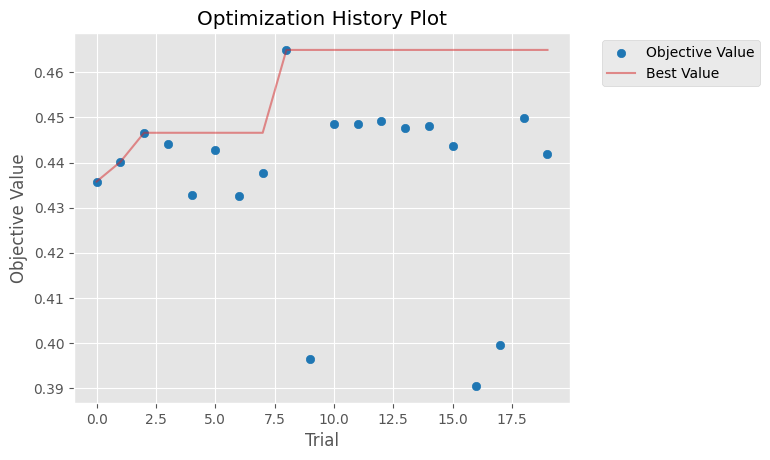

In [17]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_7672\924295173.py:1: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(


array([<Axes: xlabel='C', ylabel='Objective Value'>,
       <Axes: xlabel='max_iter'>, <Axes: xlabel='solver'>,
       <Axes: xlabel='tol'>], dtype=object)

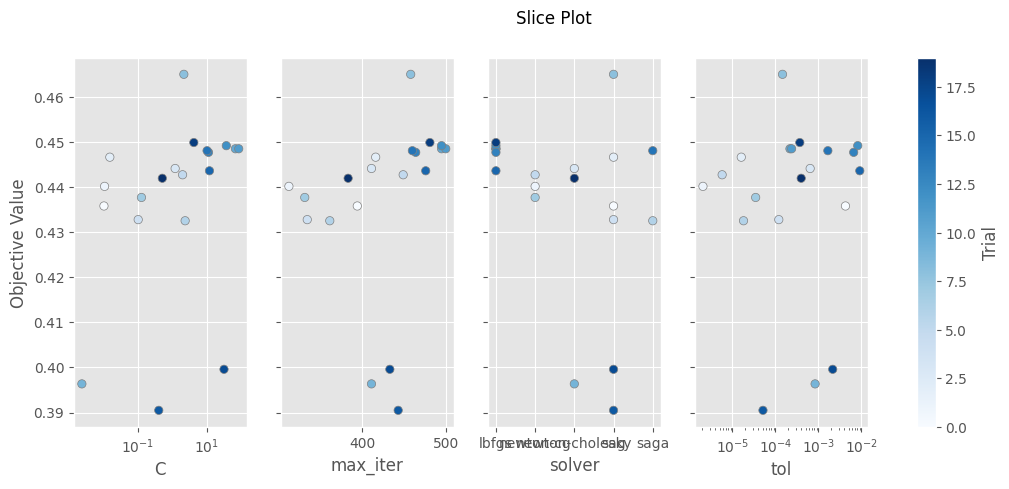

In [18]:
optuna.visualization.matplotlib.plot_slice(
    study,
    params=["C", "solver", "tol", "max_iter"],
)

C:\Users\steve\AppData\Local\Temp\ipykernel_7672\1036994904.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

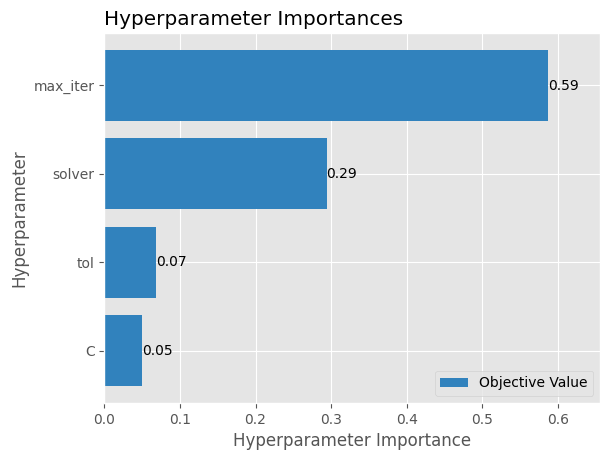

In [19]:
optuna.visualization.matplotlib.plot_param_importances(study)

C:\Users\steve\AppData\Local\Temp\ipykernel_7672\1937692550.py:1: ExperimentalWarning: plot_edf is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_edf([study])


<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

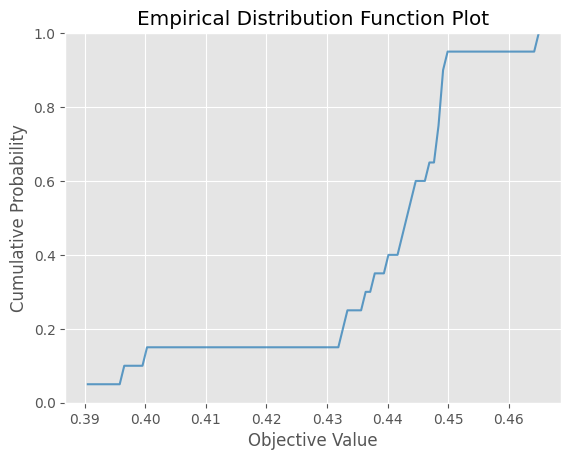

In [20]:
optuna.visualization.matplotlib.plot_edf([study])


### Classification

In [21]:
def run_model(classifier_name, sel_method, X_train, y_train):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        model = LogisticRegression(C=study.best_params['C'],
                       tol=study.best_params['tol'],
                       class_weight="balanced",
                       solver=study.best_params['solver'],
                       max_iter=study.best_params['max_iter'],
                       random_state=42)

        if sel_method == "Boruta":
                sel_method = "Boruta" 
        else: 
                sel_method = "Complete"
        
        skf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=skf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": sel_method,
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": columns,
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [22]:
scaler_t = StandardScaler()
X_train_missForest_t = scaler_t.fit_transform(X_train_knn_t)
X_test_missForest_t = scaler_t.transform(X_test_knn_t)

In [23]:
trained_lg_n, metrics_lg_n = run_model("Logistic Regression", "Complete", X_train_missForest_t, y_train)
trained_lg_t, metrics_lg_t = run_model("Logistic Regression", "Boruta", X_train_t, y_train)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did 

In [24]:
validation_df = pd.concat([metrics_lg_n, metrics_lg_t])
validation_df_report = validation_df.set_index(["Classifier", "Metric", "Feature Selection", "Fit Time", "Total Features"])
validation_df_report

Mean Train  \
Classifier          Metric            Feature Selection Fit Time Total Features               
Logistic Regression balanced_accuracy Complete          0.143    22                   0.705   
                                      Boruta            0.139    7                    0.552   

                                                                                 Std Train  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.143    22                  0.050   
                                      Boruta            0.139    7                   0.034   

                                                                                 Mean Test  \
Classifier          Metric            Feature Selection Fit Time Total Features              
Logistic Regression balanced_accuracy Complete          0.143    22                  0.429   
                                      Boruta            0.139    7                   0.465   

                                                                                 Std Test  
Classifier          Metric            Feature Selection Fit Time Total Features            
Logistic Regression balanced_accuracy Complete          0.143    22                 0.046  
                                      Boruta            0.139    7                  0.084

In [25]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        if isinstance(X_train, np.ndarray):
                columns = X_train.shape[1]
        else:
                columns = len(X_train.columns)
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted", zero_division=0), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": columns,
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [26]:
results = "all"
prediction_df_report = None

if results == "all":

    pred_ngb_n = eval_model("Logitic Regression", trained_lg_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("Logitic Regression", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":

    pred_ngb_t = eval_model("NGBoost", trained_lg_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier         Classification Time Total Features Metric                             
Boruta            Logitic Regression 0.037               22             accuracy                   0.621   
                                                                        balanced_accuracy          0.613   
                                                                        precision                  0.798   
                                                                        recall                     0.621   
                                                                        f1_weighted                0.677   
                                                                        roc_auc_ovr_weighted       0.835   
                                     0.034               7              accuracy                   0.613   
                                                                        balanced_accuracy          0.497   
                                                                        precision                  0.801   
                                                                        recall                     0.613   
                                                                        f1_weighted                0.686   
                                                                        roc_auc_ovr_weighted       0.869   

                                                                                              Test data  
Feature Selection Classifier         Classification Time Total Features Metric                           
Boruta            Logitic Regression 0.037               22             accuracy                  0.545  
                                                                        balanced_accuracy         0.311  
                                                                        precision                 0.767  
                                                                        recall                    0.545  
                                                                        f1_weighted               0.630  
                                                                        roc_auc_ovr_weighted      0.815  
                                     0.034               7              accuracy                  0.625  
                                                                        balanced_accuracy         0.395  
                                                                        precision                 0.818  
                                                                        recall                    0.625  
                                                                        f1_weighted               0.702  
                                                                        roc_auc_ovr_weighted      0.850

### Export model

In [27]:
trained_lg_t

LogisticRegression(C=2.140936020239719, class_weight='balanced', max_iter=458,
                   random_state=42, solver='sag', tol=0.00014566080448745475)

In [28]:
import pickle

# Save the trained model using pickle
with open("logit_model.pkl", "wb") as file:
    pickle.dump(trained_lg_t, file)

print("Logistic model saved successfully!")

Logistic model saved successfully!


In [29]:
# Load the saved model using pickle
with open("logit_model.pkl", "rb") as file:
    loaded_model_ngb = pickle.load(file)